# Задание Lite

Взяв за основу практический ноутбук занятия, восстановите архитектуру трансформера и обучите модель на той же базе данных.

Попробуйте обучить трансформер на 15 эпохах с количеством голов:
* num_heads = 1
* num_heads = 4
* num_heads = 8

Сравните результаты работы трансформеров с разным количеством голов и напишите выводы.

In [ ]:
# Ваше решение


In [ ]:
# Библиотека датасетов от tensorfolw
import tensorflow_datasets as tfds 

# Библиотека для обучения НС
import tensorflow as tf 

# Модуль отвечает за время и обработку временнЫх переменных
import time 

# Библиотека для работы с массивами
import numpy as np 

# Библиотека для отрисовки графиков и картинок
import matplotlib.pyplot as plt 

In [ ]:
#Для создания переводчика нам понадобится обучающая выборка с парами одинаковых предложений на португальском и английском языках. 
#Датасет возьмем из библиотеки tensorflow_datasets, который имеет имя ted_hrlr_translate/pt_to_en.

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', # Имя датасета
                               with_info=True,                # Вывести информацию о датасете
                               as_supervised=True)            # Вывод будет иметь формат (input, label)

# Разделяем на обучающую и тестовую выборки
train_examples, val_examples = examples['train'], examples['validation'] 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteXTHC1T/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteXTHC1T/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteXTHC1T/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Выведем первые 5 пар предложений
for pt, en in train_examples.take(5):
  print('Португальский:', pt.numpy())
  print('Английский:   ', en.numpy())
  print()

Португальский: b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
Английский:    b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

Португальский: b'mas e se estes fatores fossem ativos ?'
Английский:    b'but what if it were active ?'

Португальский: b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
Английский:    b"but they did n't test for curiosity ."

Португальский: b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
Английский:    b'and this conscious defiance is why i , as an agnostic , can still have faith .'

Португальский: b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
Английский:    b'you can use everything on the table on me .'



In [ ]:
# Токенайзер для английского языка, с размером словаря 2**13
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

# Токенайзер для португальского языка, с размером словаря 2**13
tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [ ]:
#Проверим как работает токенайзер на примере одной фразы
# Тестовая фраза
sample_string = 'Transformer is complicated.' 

# Перегоним слова в токены
tokenized_string = tokenizer_en.encode(sample_string) 
print('Tokenized string is {}'.format(tokenized_string))

# Перегоним токены обратно в слова
original_string = tokenizer_en.decode(tokenized_string) 
print('The original string: {}'.format(original_string))

# Распишем какой токен чему соответсвует
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_en.decode([ts]))) 

# А точно ли исходная фраза соответствует дважды перекодированной?
print(original_string == sample_string)

Tokenized string is [7915, 1248, 7946, 7194, 13, 3635, 7877]
The original string: Transformer is complicated.
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
3635 ----> complicated
7877 ----> .
True


In [ ]:
# lang1 и lang2 это языки переводчика (pt и en в нашем случае)
def encode(lang1, lang2):

  # Добавление токенов start и end первого языка (pt)
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]
  
  # Добавление токенов start и end второго языка (en)
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [ ]:
# Обертка над предыдущей функцией encode()
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode,               # Функция
                                        [pt, en],             # Аргументы 
                                        [tf.int64, tf.int64]) # Типы данных
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [ ]:
# Размер буфера в памяти при подготовке датасета
BUFFER_SIZE = 20000 

# Размер батча
BATCH_SIZE = 64  

# Максимальная длина фраз
MAX_LENGTH = 40  

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    
  return tf.logical_and(tf.size(x) <= max_length, # Маска для значений x
                        tf.size(y) <= max_length) # Маска для значений y

In [ ]:
# Прогоняем обучающие тексты через токенайзер
# Благодаря .map мы применим функцию tf_encode к каждому примеру выборки
train_dataset = train_examples.map(tf_encode) 

# Фильтруем по максимальной длинне
train_dataset = train_dataset.filter(filter_max_length) 

# Кэшируем данные в память для ускорения работы
train_dataset = train_dataset.cache() 

# Делим на батчи и перемешиваем
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE) 

# # .prefetch используется для разделения времени, когда данные производятся, 
# от времени, когда данные потребляются. Это ускоряет обучение сети
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

# Прогоняем проверочные тексты через токенайзер
val_dataset = val_examples.map(tf_encode)

# Фильтруем по максимальной длинне
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
# Возьмем первый батч датасета
pt_batch, en_batch = next(iter(val_dataset))

# Посмотрим что внутри
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [ ]:
def get_angles(pos, i, d_model):

  # По формуле рассчитаем аргументы позиционного кодирования
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  
  # Получаем аргументы
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # Чётные индексы будут принимать значение от sin
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # Нечётные индексы будут принимать значение от cos
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  # Добавляем ещё одну размерность
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


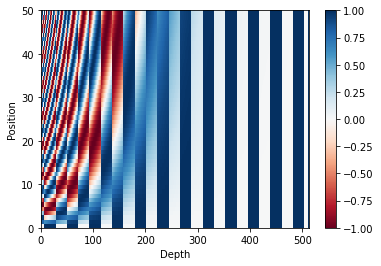

In [ ]:
# Зададим значения 50, 512
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

# Выведем значения поз. кодирования в виде heatmap
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

##num_heads = 1

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, 
               d_model = 512, # Размерность емб. пространства
               num_heads = 1, # Количество голов сети (1, 4, 8)
               causal=False,  # Применять маску в Attention или нет
               dropout=0.0):  # Значение Dropout

    super(MultiHeadAttention, self).__init__()  # Здесь все головы считаем паралелльно - поэтому attention пробегает и по батчу и по числу голов

    assert d_model % num_heads == 0 # Проверим, что размерность головы - целое цисло
    depth = d_model // num_heads    # Размерность каждой головы внимания  =>>  multi-headed_depth = depth / num_heads
                                    # Заметим, что выходы голов конкатенируются, поэтому их размер в их число раз меньше.
                                    # Поэтому размерность выхода должно совпасть в размерностью входа

    self.w_query = tf.keras.layers.Dense(d_model)                            # Dense для Query  (batch_size , seq_length, depth) 
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа query до (batch_size , seq_length, num_heads, multi_headed_depth)  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_value = tf.keras.layers.Dense(d_model)                            # Dense для Value  (batch_size , seq_length, depth)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа value до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_key = tf.keras.layers.Dense(d_model)                              # Dense для Key  (batch_size , seq_length, depth)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))   # Слой для решейпа key до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))                # Слой для перестановки размерностей для использования Attention

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout) # Прописываем слой Attention
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))             # Слой обратной перестановки размерностей
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))        # Слой обратного решейпа до размернсти модели

    self.dense = tf.keras.layers.Dense(d_model)     # Полносвязный слой

  def call(self, inputs, mask=None, training=None): # Основная рабочая функция

    q = inputs[0]                           # Вытащим входной вектор Query
    v = inputs[1]                           # Вытащим входной вектор Value
    k = inputs[2] if len(inputs) > 2 else v # Вытащим входной вектор Key

    query = self.w_query(q)                   # Прогоним через dense
    query = self.split_reshape_query(query)   # Решейпим
    query = self.split_permute_query(query)   # Переставляем размерность

    value = self.w_value(v)                 # Прогоним через dense
    value = self.split_reshape_value(value) # Решейпим
    value = self.split_permute_value(value) # Переставляем размерность

    key = self.w_key(k)               # Прогоним через dense
    key = self.split_reshape_key(key) # Решейпим
    key = self.split_permute_key(key) # Переставляем размерность

    if mask is not None: # Применим маску если есть 

      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])     # Слой для решейпа
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])      # Слой для перестановки размерностей
      
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])     # Слой для решейпа
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])      # Слой для перестановки размерностей

    attention = self.attention([query, value, key], mask=mask) # Вычисляем вектор внимания
    attention = self.join_permute_attention(attention)         # Обратно перемешиваем размерности
    attention = self.join_reshape_attention(attention)         # Решейпим до (batch_size , seq_length, depth) 

    x = self.dense(attention) # Выходной dense

    return x

In [ ]:
class EncoderLayer(tf.keras.layers.Layer): 

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 1,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout
    
    super(EncoderLayer, self).__init__()

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)   # Определим слой  MultiHeadAttention
    self.dropout_attention = tf.keras.layers.Dropout(dropout)            # Добавим дропаут
    self.add_attention = tf.keras.layers.Add()                           # Слой для получения resudial связи
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')               # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                              # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                     # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                    # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

  def call(self, inputs, mask=None, training=None):

    # Входной вектор input размножим до 3 - это query, value, key и отдадим attenton, с маской если есть 
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask]) 
    
    # Уменьшим переобучение дроаутом
    attention = self.dropout_attention(attention, training = training) 
    
    # Сделаем resudial связь - добавим входной вектор
    x = self.add_attention([inputs , attention]) 
    
    # Далее нормализация в масштабах уровня
    x = self.layer_norm_attention(x)  

    # Добавим Feed Forward  
    # Проходим 1й dense с активашкой relu
    dense = self.dense1(x) 
    
    # Второй dense без активашки т.е. с линейной активационной функцией
    dense = self.dense2(dense)  
    
    # Добавляем дропаут
    dense = self.dropout_dense(dense, training = training)  
    
    # Еще одна resudial связь
    x = self.add_dense([x , dense])  
    
    # Нормализация в масштабах уровня
    x = self.layer_norm_dense(x)  

    return x

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 1,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout

    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True) # Определим слой  MultiHeadAttention
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention1 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)                # Определим слой  MultiHeadAttention 
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention2 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')                         # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                                        # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                               # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                              # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)            # Слой нормализации

  def call(self, inputs, mask=None, training=None):
    
    # Подадим на multi-head attention  Query, Key, Value вектора - здесь это один и тот же вектор
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    
    # Пробежим дропаут
    attention = self.dropout_attention1(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([inputs[0] , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)
    
    # Второй multi-head attention. Подаем выход предыдущих слоев x и выход от энкодера, маску (если есть)
    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    
    # Прогоняем через дропаут
    attention = self.dropout_attention2(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([x , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)

    # Feed Forward
    # 1 dense + relu
    dense = self.dense1(x)

    # 2 dense +linear
    dense = self.dense2(dense)

    # Прогоняем через дропаут
    dense = self.dropout_dense(dense, training = training)

    # Пробросим Resudial-связь
    x = self.add_dense([x , dense])

    # Выполним нормализацию
    x = self.layer_norm_dense(x)

    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self, 
               input_vocab_size,                  # Размер словаря
               num_layers = 4,                    # Количество слоев энкодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 1,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True)  
    
    self.pos = positional_encoding(maximum_position_encoding,    # Функция позиционного кодирования
                                   d_model)   
                   
    self.encoder_layers = [ EncoderLayer(d_model = d_model,      # Список Nx слоев кодера
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout) for _ in range(num_layers)]  

    self.dropout = tf.keras.layers.Dropout(dropout)              # Просто дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Входной эмбеддинг  
    x = self.embedding(inputs) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Прогоняем через дропаут
    x = self.dropout(x, training=training)

    # Входной слой embedding+ Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs)

    # Прогоним через Nx слоев кодера
    for encoder_layer in self.encoder_layers: 
      x = encoder_layer(x, mask = embedding_mask)

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

In [ ]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, 
               target_vocab_size,                 # Размер словаря выходных данных
               num_layers = 4,                    # Количество слоев декодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 1,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True) 
    
    self.pos = positional_encoding(maximum_position_encoding,     # Функция позиционного кодирования
                                   d_model)                     

    self.decoder_layers = [ DecoderLayer(d_model = d_model, 
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout)  for _ in range(num_layers)] # Список Nx слоев декодера 

    self.dropout = tf.keras.layers.Dropout(dropout)               # Слой дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Выполним переход в эмбеддинг
    x = self.embedding(inputs[0]) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Просто dropout
    x = self.dropout(x, training=training)
    
    # Входной слой embedding + Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs[0])

    # Прогоним через Nx слоев декодера
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

In [ ]:
#Соберем модель: 2 входных слоя, кодер, декодер, выходной dense:

In [ ]:
num_layers = 4 # Количество слоев
d_model = 128  # Размерность емб. пространства
dff = 512      # Количество нейронов первого Dense слоя
num_heads = 1  # Количество голов

dropout_rate = 0.1 # Значение Dropout

input_vocab_size = tokenizer_pt.vocab_size + 2  # Индекс входного тега
target_vocab_size = tokenizer_en.vocab_size + 2 # Индекс выходного тега


input  = tf.keras.layers.Input(shape=(None,)) # Входной слой для переводимой фразы
target = tf.keras.layers.Input(shape=(None,)) # Вход для перевода

encoder = Encoder(input_vocab_size,           # Создаем энкодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate)  

decoder = Decoder(target_vocab_size,          # Создаем декодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate) 

# Собираем модель 
x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

# Формируем модель, выводим саммери
model = tf.keras.models.Model(inputs=[input, target], outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    1844736     ['input_1[0][0]']                
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, None)        0           ['input_1[0][0]']                
                                                                                              

2/2 [==============================] - 0s 11ms/step


(64, 40, 8089)

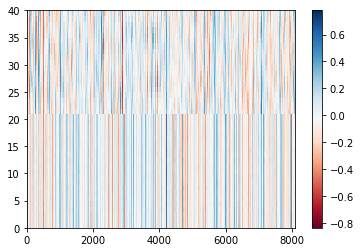

In [ ]:
# Возьмем пример данн
#Проверим работоспособность:
pt_batch, en_batch = next(iter(val_dataset))

# Выведем результат предсказания в виде тепловой карты
plt.pcolormesh(model.predict([pt_batch,en_batch])[5],cmap='RdBu')
plt.colorbar()

# Размерность предикта
model.predict([pt_batch,en_batch]).shape

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Оптимайзер 
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Функция потерь
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Мы рассчитываем потери, используя предопределенную целевую функцию, 
# а затем дополняем ее маской.

def masked_loss(y_true, y_pred):

  # Считаем маску  
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)

  # Накинем маску на потери  
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)

metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

# Количество батчей для проверки
val_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
  val_batches = batch
print(val_batches)

702
16


In [ ]:
def generator(data_set):
    
  while True:
    for pt_batch, en_batch in data_set:
      yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )

# При помощи генератора запускаем обучение
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=15,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/15
702/702 [==============================] - 66s 75ms/step - loss: 3.5417 - sparse_categorical_crossentropy: 7.1069 - masked_loss: 7.2491 - sparse_categorical_accuracy: 0.0954 - val_loss: 2.7892 - val_sparse_categorical_crossentropy: 5.6845 - val_masked_loss: 6.0065 - val_sparse_categorical_accuracy: 0.1978
Epoch 2/15
702/702 [==============================] - 50s 71ms/step - loss: 2.5456 - sparse_categorical_crossentropy: 5.1088 - masked_loss: 5.3939 - sparse_categorical_accuracy: 0.2556 - val_loss: 2.3091 - val_sparse_categorical_crossentropy: 4.7061 - val_masked_loss: 4.9775 - val_sparse_categorical_accuracy: 0.2983
Epoch 3/15
702/702 [==============================] - 51s 73ms/step - loss: 2.2826 - sparse_categorical_crossentropy: 4.5827 - masked_loss: 4.8393 - sparse_categorical_accuracy: 0.3024 - val_loss: 2.1935 - val_sparse_categorical_crossentropy: 4.4705 - val_masked_loss: 4.7283 - val_sparse_categorical_accuracy: 0.3145
Epoch 4/15
702/702 [==========================

In [ ]:
# Возьмем первые 10 значений данных
for i in range(10):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([pt_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

1/1 [==============================] - 0s 35ms/step
Реальный перевод:      did they eat fish and chips ?
Перевод трансформером: what do you see that mean ?

1/1 [==============================] - 0s 34ms/step
Реальный перевод:      i was always worried about being caught and sent back .
Перевод трансформером: and i was not a little bit of the first time .

1/1 [==============================] - 0s 35ms/step
Реальный перевод:      i chose one with the skin color of a lobster when sunburnt .
Перевод трансформером: and the first thing is that we can see is the world .

1/1 [==============================] - 0s 40ms/step
Реальный перевод:      but i think this is quite clearly untrue .
Перевод трансформером: i think it 's a little bit of my life .

1/1 [==============================] - 0s 36ms/step
Реальный перевод:      we have measured our progress very rigorously .
Перевод трансформером: and the first thing is the first time .

1/1 [==============================] - 0s 34ms/step
Реальн

##num_heads = 4


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, 
               d_model = 512, # Размерность емб. пространства
               num_heads = 4, # Количество голов сети (1, 4, 8)
               causal=False,  # Применять маску в Attention или нет
               dropout=0.0):  # Значение Dropout

    super(MultiHeadAttention, self).__init__()  # Здесь все головы считаем паралелльно - поэтому attention пробегает и по батчу и по числу голов

    assert d_model % num_heads == 0 # Проверим, что размерность головы - целое цисло
    depth = d_model // num_heads    # Размерность каждой головы внимания  =>>  multi-headed_depth = depth / num_heads
                                    # Заметим, что выходы голов конкатенируются, поэтому их размер в их число раз меньше.
                                    # Поэтому размерность выхода должно совпасть в размерностью входа

    self.w_query = tf.keras.layers.Dense(d_model)                            # Dense для Query  (batch_size , seq_length, depth) 
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа query до (batch_size , seq_length, num_heads, multi_headed_depth)  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_value = tf.keras.layers.Dense(d_model)                            # Dense для Value  (batch_size , seq_length, depth)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа value до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_key = tf.keras.layers.Dense(d_model)                              # Dense для Key  (batch_size , seq_length, depth)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))   # Слой для решейпа key до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))                # Слой для перестановки размерностей для использования Attention

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout) # Прописываем слой Attention
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))             # Слой обратной перестановки размерностей
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))        # Слой обратного решейпа до размернсти модели

    self.dense = tf.keras.layers.Dense(d_model)     # Полносвязный слой

  def call(self, inputs, mask=None, training=None): # Основная рабочая функция

    q = inputs[0]                           # Вытащим входной вектор Query
    v = inputs[1]                           # Вытащим входной вектор Value
    k = inputs[2] if len(inputs) > 2 else v # Вытащим входной вектор Key

    query = self.w_query(q)                   # Прогоним через dense
    query = self.split_reshape_query(query)   # Решейпим
    query = self.split_permute_query(query)   # Переставляем размерность

    value = self.w_value(v)                 # Прогоним через dense
    value = self.split_reshape_value(value) # Решейпим
    value = self.split_permute_value(value) # Переставляем размерность

    key = self.w_key(k)               # Прогоним через dense
    key = self.split_reshape_key(key) # Решейпим
    key = self.split_permute_key(key) # Переставляем размерность

    if mask is not None: # Применим маску если есть 

      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])     # Слой для решейпа
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])      # Слой для перестановки размерностей
      
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])     # Слой для решейпа
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])      # Слой для перестановки размерностей

    attention = self.attention([query, value, key], mask=mask) # Вычисляем вектор внимания
    attention = self.join_permute_attention(attention)         # Обратно перемешиваем размерности
    attention = self.join_reshape_attention(attention)         # Решейпим до (batch_size , seq_length, depth) 

    x = self.dense(attention) # Выходной dense

    return x

In [ ]:
class EncoderLayer(tf.keras.layers.Layer): 

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 4,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout
    
    super(EncoderLayer, self).__init__()

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)   # Определим слой  MultiHeadAttention
    self.dropout_attention = tf.keras.layers.Dropout(dropout)            # Добавим дропаут
    self.add_attention = tf.keras.layers.Add()                           # Слой для получения resudial связи
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')               # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                              # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                     # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                    # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

  def call(self, inputs, mask=None, training=None):

    # Входной вектор input размножим до 3 - это query, value, key и отдадим attenton, с маской если есть 
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask]) 
    
    # Уменьшим переобучение дроаутом
    attention = self.dropout_attention(attention, training = training) 
    
    # Сделаем resudial связь - добавим входной вектор
    x = self.add_attention([inputs , attention]) 
    
    # Далее нормализация в масштабах уровня
    x = self.layer_norm_attention(x)  

    # Добавим Feed Forward  
    # Проходим 1й dense с активашкой relu
    dense = self.dense1(x) 
    
    # Второй dense без активашки т.е. с линейной активационной функцией
    dense = self.dense2(dense)  
    
    # Добавляем дропаут
    dense = self.dropout_dense(dense, training = training)  
    
    # Еще одна resudial связь
    x = self.add_dense([x , dense])  
    
    # Нормализация в масштабах уровня
    x = self.layer_norm_dense(x)  

    return x

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 4,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout

    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True) # Определим слой  MultiHeadAttention
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention1 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)                # Определим слой  MultiHeadAttention 
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention2 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')                         # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                                        # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                               # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                              # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)            # Слой нормализации

  def call(self, inputs, mask=None, training=None):
    
    # Подадим на multi-head attention  Query, Key, Value вектора - здесь это один и тот же вектор
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    
    # Пробежим дропаут
    attention = self.dropout_attention1(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([inputs[0] , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)
    
    # Второй multi-head attention. Подаем выход предыдущих слоев x и выход от энкодера, маску (если есть)
    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    
    # Прогоняем через дропаут
    attention = self.dropout_attention2(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([x , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)

    # Feed Forward
    # 1 dense + relu
    dense = self.dense1(x)

    # 2 dense +linear
    dense = self.dense2(dense)

    # Прогоняем через дропаут
    dense = self.dropout_dense(dense, training = training)

    # Пробросим Resudial-связь
    x = self.add_dense([x , dense])

    # Выполним нормализацию
    x = self.layer_norm_dense(x)

    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self, 
               input_vocab_size,                  # Размер словаря
               num_layers = 4,                    # Количество слоев энкодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 4,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True)  
    
    self.pos = positional_encoding(maximum_position_encoding,    # Функция позиционного кодирования
                                   d_model)   
                   
    self.encoder_layers = [ EncoderLayer(d_model = d_model,      # Список Nx слоев кодера
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout) for _ in range(num_layers)]  

    self.dropout = tf.keras.layers.Dropout(dropout)              # Просто дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Входной эмбеддинг  
    x = self.embedding(inputs) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Прогоняем через дропаут
    x = self.dropout(x, training=training)

    # Входной слой embedding+ Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs)

    # Прогоним через Nx слоев кодера
    for encoder_layer in self.encoder_layers: 
      x = encoder_layer(x, mask = embedding_mask)

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

In [ ]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, 
               target_vocab_size,                 # Размер словаря выходных данных
               num_layers = 4,                    # Количество слоев декодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 4,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True) 
    
    self.pos = positional_encoding(maximum_position_encoding,     # Функция позиционного кодирования
                                   d_model)                     

    self.decoder_layers = [ DecoderLayer(d_model = d_model, 
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout)  for _ in range(num_layers)] # Список Nx слоев декодера 

    self.dropout = tf.keras.layers.Dropout(dropout)               # Слой дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Выполним переход в эмбеддинг
    x = self.embedding(inputs[0]) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Просто dropout
    x = self.dropout(x, training=training)
    
    # Входной слой embedding + Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs[0])

    # Прогоним через Nx слоев декодера
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

In [ ]:
#Соберем модель: 2 входных слоя, кодер, декодер, выходной dense:

In [ ]:
num_layers = 4 # Количество слоев
d_model = 128  # Размерность емб. пространства
dff = 512      # Количество нейронов первого Dense слоя
num_heads = 4  # Количество голов

dropout_rate = 0.1 # Значение Dropout

input_vocab_size = tokenizer_pt.vocab_size + 2  # Индекс входного тега
target_vocab_size = tokenizer_en.vocab_size + 2 # Индекс выходного тега


input  = tf.keras.layers.Input(shape=(None,)) # Входной слой для переводимой фразы
target = tf.keras.layers.Input(shape=(None,)) # Вход для перевода

encoder = Encoder(input_vocab_size,           # Создаем энкодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate)  

decoder = Decoder(target_vocab_size,          # Создаем декодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate) 

# Собираем модель 
x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

# Формируем модель, выводим саммери
model = tf.keras.models.Model(inputs=[input, target], outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder_1 (Encoder)            (None, None, 128)    1844736     ['input_3[0][0]']                
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, None)        0           ['input_3[0][0]']                
 a)                                                                                         

2/2 [==============================] - 0s 10ms/step


(64, 40, 8089)

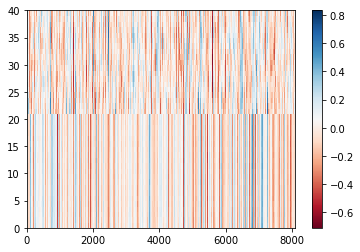

In [ ]:
# Возьмем пример данн
#Проверим работоспособность:
pt_batch, en_batch = next(iter(val_dataset))

# Выведем результат предсказания в виде тепловой карты
plt.pcolormesh(model.predict([pt_batch,en_batch])[5],cmap='RdBu')
plt.colorbar()

# Размерность предикта
model.predict([pt_batch,en_batch]).shape

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Оптимайзер 
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Функция потерь
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Мы рассчитываем потери, используя предопределенную целевую функцию, 
# а затем дополняем ее маской.

def masked_loss(y_true, y_pred):

  # Считаем маску  
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)

  # Накинем маску на потери  
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)

metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

# Количество батчей для проверки
val_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
  val_batches = batch
print(val_batches)

702
16


In [ ]:
def generator(data_set):
    
  while True:
    for pt_batch, en_batch in data_set:
      yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )

# При помощи генератора запускаем обучение
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=15,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/15
702/702 [==============================] - 69s 81ms/step - loss: 3.5142 - sparse_categorical_crossentropy: 7.0682 - masked_loss: 7.2122 - sparse_categorical_accuracy: 0.1152 - val_loss: 2.7262 - val_sparse_categorical_crossentropy: 5.5562 - val_masked_loss: 5.8714 - val_sparse_categorical_accuracy: 0.2108
Epoch 2/15
702/702 [==============================] - 52s 73ms/step - loss: 2.4804 - sparse_categorical_crossentropy: 4.9790 - masked_loss: 5.2569 - sparse_categorical_accuracy: 0.2707 - val_loss: 2.2482 - val_sparse_categorical_crossentropy: 4.5820 - val_masked_loss: 4.8463 - val_sparse_categorical_accuracy: 0.3151
Epoch 3/15
702/702 [==============================] - 51s 73ms/step - loss: 2.1927 - sparse_categorical_crossentropy: 4.4028 - masked_loss: 4.6493 - sparse_categorical_accuracy: 0.3316 - val_loss: 2.0374 - val_sparse_categorical_crossentropy: 4.1523 - val_masked_loss: 4.3917 - val_sparse_categorical_accuracy: 0.3725
Epoch 4/15
702/702 [==========================

In [ ]:
# Возьмем первые 10 значений данных
for i in range(10):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([pt_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

1/1 [==============================] - 0s 49ms/step
Реальный перевод:      did they eat fish and chips ?
Перевод трансформером: did you have the fish with the bottles ?

1/1 [==============================] - 0s 35ms/step
Реальный перевод:      i was always worried about being caught and sent back .
Перевод трансформером: i was always concerned about being stuck and they send it back .

1/1 [==============================] - 0s 34ms/step
Реальный перевод:      i chose one with the skin color of a lobster when sunburnt .
Перевод трансформером: i chose to talk to a wan eye with a rain .

1/1 [==============================] - 0s 40ms/step
Реальный перевод:      but i think this is quite clearly untrue .
Перевод трансформером: but i think this is clearly a forger .

1/1 [==============================] - 0s 44ms/step
Реальный перевод:      we have measured our progress very rigorously .
Перевод трансформером: we have the extreme our progressive progressive progressive .

1/1 [============

##num_heads = 8

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, 
               d_model = 512, # Размерность емб. пространства
               num_heads = 8, # Количество голов сети (1, 4, 8)
               causal=False,  # Применять маску в Attention или нет
               dropout=0.0):  # Значение Dropout

    super(MultiHeadAttention, self).__init__()  # Здесь все головы считаем паралелльно - поэтому attention пробегает и по батчу и по числу голов

    assert d_model % num_heads == 0 # Проверим, что размерность головы - целое цисло
    depth = d_model // num_heads    # Размерность каждой головы внимания  =>>  multi-headed_depth = depth / num_heads
                                    # Заметим, что выходы голов конкатенируются, поэтому их размер в их число раз меньше.
                                    # Поэтому размерность выхода должно совпасть в размерностью входа

    self.w_query = tf.keras.layers.Dense(d_model)                            # Dense для Query  (batch_size , seq_length, depth) 
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа query до (batch_size , seq_length, num_heads, multi_headed_depth)  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_value = tf.keras.layers.Dense(d_model)                            # Dense для Value  (batch_size , seq_length, depth)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа value до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_key = tf.keras.layers.Dense(d_model)                              # Dense для Key  (batch_size , seq_length, depth)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))   # Слой для решейпа key до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))                # Слой для перестановки размерностей для использования Attention

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout) # Прописываем слой Attention
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))             # Слой обратной перестановки размерностей
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))        # Слой обратного решейпа до размернсти модели

    self.dense = tf.keras.layers.Dense(d_model)     # Полносвязный слой

  def call(self, inputs, mask=None, training=None): # Основная рабочая функция

    q = inputs[0]                           # Вытащим входной вектор Query
    v = inputs[1]                           # Вытащим входной вектор Value
    k = inputs[2] if len(inputs) > 2 else v # Вытащим входной вектор Key

    query = self.w_query(q)                   # Прогоним через dense
    query = self.split_reshape_query(query)   # Решейпим
    query = self.split_permute_query(query)   # Переставляем размерность

    value = self.w_value(v)                 # Прогоним через dense
    value = self.split_reshape_value(value) # Решейпим
    value = self.split_permute_value(value) # Переставляем размерность

    key = self.w_key(k)               # Прогоним через dense
    key = self.split_reshape_key(key) # Решейпим
    key = self.split_permute_key(key) # Переставляем размерность

    if mask is not None: # Применим маску если есть 

      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])     # Слой для решейпа
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])      # Слой для перестановки размерностей
      
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])     # Слой для решейпа
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])      # Слой для перестановки размерностей

    attention = self.attention([query, value, key], mask=mask) # Вычисляем вектор внимания
    attention = self.join_permute_attention(attention)         # Обратно перемешиваем размерности
    attention = self.join_reshape_attention(attention)         # Решейпим до (batch_size , seq_length, depth) 

    x = self.dense(attention) # Выходной dense

    return x

In [ ]:
class EncoderLayer(tf.keras.layers.Layer): 

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 8,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout
    
    super(EncoderLayer, self).__init__()

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)   # Определим слой  MultiHeadAttention
    self.dropout_attention = tf.keras.layers.Dropout(dropout)            # Добавим дропаут
    self.add_attention = tf.keras.layers.Add()                           # Слой для получения resudial связи
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')               # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                              # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                     # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                    # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

  def call(self, inputs, mask=None, training=None):

    # Входной вектор input размножим до 3 - это query, value, key и отдадим attenton, с маской если есть 
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask]) 
    
    # Уменьшим переобучение дроаутом
    attention = self.dropout_attention(attention, training = training) 
    
    # Сделаем resudial связь - добавим входной вектор
    x = self.add_attention([inputs , attention]) 
    
    # Далее нормализация в масштабах уровня
    x = self.layer_norm_attention(x)  

    # Добавим Feed Forward  
    # Проходим 1й dense с активашкой relu
    dense = self.dense1(x) 
    
    # Второй dense без активашки т.е. с линейной активационной функцией
    dense = self.dense2(dense)  
    
    # Добавляем дропаут
    dense = self.dropout_dense(dense, training = training)  
    
    # Еще одна resudial связь
    x = self.add_dense([x , dense])  
    
    # Нормализация в масштабах уровня
    x = self.layer_norm_dense(x)  

    return x

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 8,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout

    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True) # Определим слой  MultiHeadAttention
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention1 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)                # Определим слой  MultiHeadAttention 
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention2 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')                         # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                                        # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                               # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                              # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)            # Слой нормализации

  def call(self, inputs, mask=None, training=None):
    
    # Подадим на multi-head attention  Query, Key, Value вектора - здесь это один и тот же вектор
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    
    # Пробежим дропаут
    attention = self.dropout_attention1(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([inputs[0] , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)
    
    # Второй multi-head attention. Подаем выход предыдущих слоев x и выход от энкодера, маску (если есть)
    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    
    # Прогоняем через дропаут
    attention = self.dropout_attention2(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([x , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)

    # Feed Forward
    # 1 dense + relu
    dense = self.dense1(x)

    # 2 dense +linear
    dense = self.dense2(dense)

    # Прогоняем через дропаут
    dense = self.dropout_dense(dense, training = training)

    # Пробросим Resudial-связь
    x = self.add_dense([x , dense])

    # Выполним нормализацию
    x = self.layer_norm_dense(x)

    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self, 
               input_vocab_size,                  # Размер словаря
               num_layers = 4,                    # Количество слоев энкодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 8,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True)  
    
    self.pos = positional_encoding(maximum_position_encoding,    # Функция позиционного кодирования
                                   d_model)   
                   
    self.encoder_layers = [ EncoderLayer(d_model = d_model,      # Список Nx слоев кодера
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout) for _ in range(num_layers)]  

    self.dropout = tf.keras.layers.Dropout(dropout)              # Просто дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Входной эмбеддинг  
    x = self.embedding(inputs) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Прогоняем через дропаут
    x = self.dropout(x, training=training)

    # Входной слой embedding+ Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs)

    # Прогоним через Nx слоев кодера
    for encoder_layer in self.encoder_layers: 
      x = encoder_layer(x, mask = embedding_mask)

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

In [ ]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, 
               target_vocab_size,                 # Размер словаря выходных данных
               num_layers = 4,                    # Количество слоев декодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 8,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True) 
    
    self.pos = positional_encoding(maximum_position_encoding,     # Функция позиционного кодирования
                                   d_model)                     

    self.decoder_layers = [ DecoderLayer(d_model = d_model, 
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout)  for _ in range(num_layers)] # Список Nx слоев декодера 

    self.dropout = tf.keras.layers.Dropout(dropout)               # Слой дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Выполним переход в эмбеддинг
    x = self.embedding(inputs[0]) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Просто dropout
    x = self.dropout(x, training=training)
    
    # Входной слой embedding + Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs[0])

    # Прогоним через Nx слоев декодера
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

In [ ]:
#Соберем модель: 2 входных слоя, кодер, декодер, выходной dense:

In [ ]:
num_layers = 4 # Количество слоев
d_model = 128  # Размерность емб. пространства
dff = 512      # Количество нейронов первого Dense слоя
num_heads = 8  # Количество голов

dropout_rate = 0.1 # Значение Dropout

input_vocab_size = tokenizer_pt.vocab_size + 2  # Индекс входного тега
target_vocab_size = tokenizer_en.vocab_size + 2 # Индекс выходного тега


input  = tf.keras.layers.Input(shape=(None,)) # Входной слой для переводимой фразы
target = tf.keras.layers.Input(shape=(None,)) # Вход для перевода

encoder = Encoder(input_vocab_size,           # Создаем энкодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate)  

decoder = Decoder(target_vocab_size,          # Создаем декодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate) 

# Собираем модель 
x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

# Формируем модель, выводим саммери
model = tf.keras.models.Model(inputs=[input, target], outputs=x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder_2 (Encoder)            (None, None, 128)    1844736     ['input_5[0][0]']                
                                                                                                  
 tf.math.not_equal_2 (TFOpLambd  (None, None)        0           ['input_5[0][0]']                
 a)                                                                                         

2/2 [==============================] - 0s 11ms/step


(64, 40, 8089)

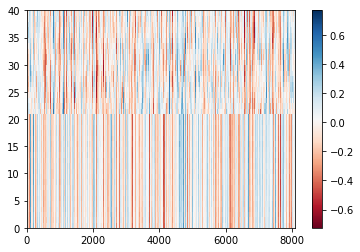

In [ ]:
# Возьмем пример данн
#Проверим работоспособность:
pt_batch, en_batch = next(iter(val_dataset))

# Выведем результат предсказания в виде тепловой карты
plt.pcolormesh(model.predict([pt_batch,en_batch])[5],cmap='RdBu')
plt.colorbar()

# Размерность предикта
model.predict([pt_batch,en_batch]).shape

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Оптимайзер 
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Функция потерь
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Мы рассчитываем потери, используя предопределенную целевую функцию, 
# а затем дополняем ее маской.

def masked_loss(y_true, y_pred):

  # Считаем маску  
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)

  # Накинем маску на потери  
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)

metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

# Количество батчей для проверки
val_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
  val_batches = batch
print(val_batches)

702
16


In [ ]:
def generator(data_set):
    
  while True:
    for pt_batch, en_batch in data_set:
      yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )

# При помощи генератора запускаем обучение
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=15,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/15
702/702 [==============================] - 71s 80ms/step - loss: 3.4976 - sparse_categorical_crossentropy: 7.0221 - masked_loss: 7.1793 - sparse_categorical_accuracy: 0.1304 - val_loss: 2.6712 - val_sparse_categorical_crossentropy: 5.4440 - val_masked_loss: 5.7544 - val_sparse_categorical_accuracy: 0.2295
Epoch 2/15
702/702 [==============================] - 53s 76ms/step - loss: 2.4399 - sparse_categorical_crossentropy: 4.8980 - masked_loss: 5.1716 - sparse_categorical_accuracy: 0.2818 - val_loss: 2.2246 - val_sparse_categorical_crossentropy: 4.5339 - val_masked_loss: 4.7954 - val_sparse_categorical_accuracy: 0.3272
Epoch 3/15
702/702 [==============================] - 53s 76ms/step - loss: 2.1718 - sparse_categorical_crossentropy: 4.3577 - masked_loss: 4.6017 - sparse_categorical_accuracy: 0.3378 - val_loss: 2.0246 - val_sparse_categorical_crossentropy: 4.1261 - val_masked_loss: 4.3641 - val_sparse_categorical_accuracy: 0.3709
Epoch 4/15
702/702 [==========================

In [ ]:
# Возьмем первые 10 значений данных
for i in range(10):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([pt_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

1/1 [==============================] - 0s 34ms/step
Реальный перевод:      did they eat fish and chips ?
Перевод трансформером: they were there to the fish with a lot of prisoners in a lot ?

1/1 [==============================] - 0s 36ms/step
Реальный перевод:      i was always worried about being caught and sent back .
Перевод трансформером: it was always worrying to being caught up and send it back .

1/1 [==============================] - 0s 33ms/step
Реальный перевод:      i chose one with the skin color of a lobster when sunburnt .
Перевод трансформером: i chose with a cancer of a field of a pscil with a dinosaur .

1/1 [==============================] - 0s 34ms/step
Реальный перевод:      but i think this is quite clearly untrue .
Перевод трансформером: but i think this is clearly fake .

1/1 [==============================] - 0s 33ms/step
Реальный перевод:      we have measured our progress very rigorously .
Перевод трансформером: we have to measure our very strong evolutionary

## Вывод:


1 вариант num_heads = 1 и 15 эпох показали результат: 
val_sparse_categorical_accuracy: 0.3505. Совпадений в переводе не обнаружено.

2 вариант num_heads = 4 и 15 эпох показали результат: 
val_sparse_categorical_accuracy: 0.5564. Качество перевода улучшилось, появились совпадения первой части предложения.

3 вариант num_heads = 8 и 15 эпох показали результат: 
val_sparse_categorical_accuracy: 0.6171. Качество перевода улучшилось, появились совпадения первой части предложения и последующей.